# Battle of the Neighbourhoods Capstone Project

## Business Problem

Company XYZ Ltd (XYZ) is considering whether to open a new bar in Darwin city, located in Northern Territory Australia. However, XYZ is wondering whether right now is a good time to invest, and additionally where in the Darwin CBD should they open the establishment if they choose to proceed.

## Data Sources

#### Data 1: 
Foursquare API of nightlife spots within a 1km radius of Darwin city

#### Data 2:
Economic Data for the Northern Territory from the Australian Bureau of Statistics. This data includes state final demand (measure for how much is produced in the economy), unemployment rate, private wages growth and population figures. 

## Methodology

#### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

print('Libraries imported.')

Libraries imported.


### Gather Data 1

#### Foresquare API Credentials

In [2]:
CLIENT_ID = 'BD33KDBZF1A2KN05344L2CH4P0X5FMTRO5FLQHOLVHLYQKMO' # your Foursquare ID
CLIENT_SECRET = 'YHUROMJATH4WUXQCZKI4G5BX2PGCJBN30E3NNMY3RR1XGFTO' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BD33KDBZF1A2KN05344L2CH4P0X5FMTRO5FLQHOLVHLYQKMO
CLIENT_SECRET:YHUROMJATH4WUXQCZKI4G5BX2PGCJBN30E3NNMY3RR1XGFTO


In [3]:
address = 'Darwin city, NT'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-12.460834 130.844442


#### Get Data 1

In [4]:
LIMIT =50
radius = 1000
categoryId = '4d4b7105d754a06376d81259' #code represents nightlife spots


url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,
    radius,
    LIMIT,
    categoryId)
url

'https://api.foursquare.com/v2/venues/search?&client_id=BD33KDBZF1A2KN05344L2CH4P0X5FMTRO5FLQHOLVHLYQKMO&client_secret=YHUROMJATH4WUXQCZKI4G5BX2PGCJBN30E3NNMY3RR1XGFTO&v=20180604&ll=-12.460834,130.844442&radius=1000&limit=50&categoryId=4d4b7105d754a06376d81259'

In [5]:
results = requests.get(url).json()

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [41]:
venues = results['response']['venues']
    
nearby_venues = json_normalize(venues) # flatten JSON

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in nearby_venues.columns if col.startswith('location.')] + ['id']
dataframe_filtered = nearby_venues.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,The Cav,Australian Restaurant,12 Cavenagh St.,AU,Darwin,Australia,NaN,261,"[12 Cavenagh St., Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.4630925779837...",-12.463093,130.843792,0800,NT,4c5ba5a085a1e21ee4b05411
1,Time Nightclub,Nightclub,NaN,AU,NaN,Australia,NaN,327,[Australia],"[{'label': 'display', 'lat': -12.4610013961792...",-12.461001,130.841431,NaN,NaN,4fd4d5d2e4b0052fbc1fb3cb
2,Stone House Wine Bar,Wine Bar,NaN,AU,NaN,Australia,NaN,243,[Australia],"[{'label': 'display', 'lat': -12.46169, 'lng':...",-12.461690,130.842377,NaN,NaN,5820316afa17e5344af78140
3,The Lost Arc,Pub,NaN,AU,NaN,Australia,NaN,777,[Australia],"[{'label': 'display', 'lat': -12.4606198865739...",-12.460620,130.837295,NaN,NaN,522b1a4c11d2349c631e9310
4,Six Tanks Brew Co,Brewery,4/69 Mitchell St,AU,Darwin,Australia,NaN,606,"[4/69 Mitchell St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.462574, 'lng'...",-12.462574,130.839157,0800,NT,58380c1bf229952c8d2a081a
5,Darwin RSL,Sports Bar,NaN,AU,NaN,Australia,NaN,260,[Australia],"[{'label': 'display', 'lat': -12.4625077351637...",-12.462508,130.842764,NaN,NaN,4f869690e4b0da7775226ba2
6,The Traders Bar,Other Nightlife,NaN,AU,NaN,Australia,NaN,1039,[Australia],"[{'label': 'display', 'lat': -12.456752, 'lng'...",-12.456752,130.835840,NaN,NaN,585cf995a598b31319c2f8f2
7,Tap on Mitchell,Bar,NaN,AU,NaN,Australia,NaN,583,[Australia],"[{'label': 'display', 'lat': -12.4627837675649...",-12.462784,130.839461,NaN,NaN,53ede204498e1f31ed98fa07
8,Darwin Escorts,Strip Club,NaN,AU,NaN,Australia,NaN,376,[Australia],"[{'label': 'display', 'lat': -12.4577282033474...",-12.457728,130.843080,NaN,NaN,4eccd729490144fb1f72dcb1
9,Throb,Gay Bar,NaN,AU,NaN,Australia,NaN,488,[Australia],"[{'label': 'display', 'lat': -12.4620555561011...",-12.462056,130.840130,NaN,NaN,4c302193452620a1a4cb1e0f


In [43]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Darwin CBD

# add a red circle marker to represent the Darwin CBD
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Darwin CBD',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)


# display map
venues_map

#### Remove data that is no applicable (eg venues that have closed, do not exist etc) 

In [42]:
dataframe_filtered = dataframe_filtered.drop([dataframe_filtered.index[36] , dataframe_filtered.index[14], dataframe_filtered.index[12], dataframe_filtered.index[5], dataframe_filtered.index[1], dataframe_filtered.index[29], dataframe_filtered.index[34], dataframe_filtered.index[30], dataframe_filtered.index[28], dataframe_filtered.index[21], dataframe_filtered.index[24], dataframe_filtered.index[19], dataframe_filtered.index[17], dataframe_filtered.index[10], dataframe_filtered.index[13], dataframe_filtered.index[11], dataframe_filtered.index[8], dataframe_filtered.index[32], dataframe_filtered.index[15], dataframe_filtered.index[9]])      
dataframe_filtered.reset_index(inplace = True)
dataframe_filtered.drop('index', axis=1,inplace=True)
df = dataframe_filtered
df

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,The Cav,Australian Restaurant,12 Cavenagh St.,AU,Darwin,Australia,NaN,261,"[12 Cavenagh St., Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.4630925779837...",-12.463093,130.843792,0800,NT,4c5ba5a085a1e21ee4b05411
1,Stone House Wine Bar,Wine Bar,NaN,AU,NaN,Australia,NaN,243,[Australia],"[{'label': 'display', 'lat': -12.46169, 'lng':...",-12.461690,130.842377,NaN,NaN,5820316afa17e5344af78140
2,The Lost Arc,Pub,NaN,AU,NaN,Australia,NaN,777,[Australia],"[{'label': 'display', 'lat': -12.4606198865739...",-12.460620,130.837295,NaN,NaN,522b1a4c11d2349c631e9310
3,Six Tanks Brew Co,Brewery,4/69 Mitchell St,AU,Darwin,Australia,NaN,606,"[4/69 Mitchell St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.462574, 'lng'...",-12.462574,130.839157,0800,NT,58380c1bf229952c8d2a081a
4,The Traders Bar,Other Nightlife,NaN,AU,NaN,Australia,NaN,1039,[Australia],"[{'label': 'display', 'lat': -12.456752, 'lng'...",-12.456752,130.835840,NaN,NaN,585cf995a598b31319c2f8f2
5,Tap on Mitchell,Bar,NaN,AU,NaN,Australia,NaN,583,[Australia],"[{'label': 'display', 'lat': -12.4627837675649...",-12.462784,130.839461,NaN,NaN,53ede204498e1f31ed98fa07
6,Fiddler's Green,Pub,Wharf One,AU,Darwin,Australia,19 Kitchener Dr.,746,"[Wharf One (19 Kitchener Dr.), Darwin NT 0800,...","[{'label': 'display', 'lat': -12.4673657513882...",-12.467366,130.846016,0800,NT,4cb52c59b315a0937cf39276
7,Hotel Darwin,Hotel Bar,Mitchell Street,AU,Darwin,Australia,NaN,545,"[Mitchell Street, Darwin NT, Australia]","[{'label': 'display', 'lat': -12.4650560026868...",-12.465056,130.841889,NaN,NT,51567ea2e4b0226f7bcbedda
8,Throb Nightclub,Gay Bar,Level 1/64 Smith Street,AU,Darwin,Australia,NaN,416,"[Level 1/64 Smith Street, Darwin NT 0800, Aust...","[{'label': 'display', 'lat': -12.4621343633869...",-12.462134,130.840845,0800,NT,4ca72d3ad971b1f78a2107e1
9,Darwin Hotel,Bar,NaN,AU,Darwin,Australia,NaN,558,"[Darwin NT, Australia]","[{'label': 'display', 'lat': -12.4651315909236...",-12.465132,130.841788,NaN,NT,508a76bae4b0578944749668


#### Display Venues on a Map

#### It appears most venues are located on mitchel street, lets add a dummy column to the dataframe to highlight this fact. Due to the inconsistency of the way address is formatted, il do this manually

### Cluster Analysis

In [44]:
df.insert(2, 'Mitchell Street Dummy', [0,0,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1,0], True)
df

,name,categories,Mitchell Street Dummy,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,The Cav,Australian Restaurant,0,12 Cavenagh St.,AU,Darwin,Australia,NaN,261,"[12 Cavenagh St., Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.4630925779837...",-12.463093,130.843792,0800,NT,4c5ba5a085a1e21ee4b05411
1,Stone House Wine Bar,Wine Bar,0,NaN,AU,NaN,Australia,NaN,243,[Australia],"[{'label': 'display', 'lat': -12.46169, 'lng':...",-12.461690,130.842377,NaN,NaN,5820316afa17e5344af78140
2,The Lost Arc,Pub,1,NaN,AU,NaN,Australia,NaN,777,[Australia],"[{'label': 'display', 'lat': -12.4606198865739...",-12.460620,130.837295,NaN,NaN,522b1a4c11d2349c631e9310
3,Six Tanks Brew Co,Brewery,1,4/69 Mitchell St,AU,Darwin,Australia,NaN,606,"[4/69 Mitchell St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.462574, 'lng'...",-12.462574,130.839157,0800,NT,58380c1bf229952c8d2a081a
4,The Traders Bar,Other Nightlife,0,NaN,AU,NaN,Australia,NaN,1039,[Australia],"[{'label': 'display', 'lat': -12.456752, 'lng'...",-12.456752,130.835840,NaN,NaN,585cf995a598b31319c2f8f2
5,Tap on Mitchell,Bar,1,NaN,AU,NaN,Australia,NaN,583,[Australia],"[{'label': 'display', 'lat': -12.4627837675649...",-12.462784,130.839461,NaN,NaN,53ede204498e1f31ed98fa07
6,Fiddler's Green,Pub,0,Wharf One,AU,Darwin,Australia,19 Kitchener Dr.,746,"[Wharf One (19 Kitchener Dr.), Darwin NT 0800,...","[{'label': 'display', 'lat': -12.4673657513882...",-12.467366,130.846016,0800,NT,4cb52c59b315a0937cf39276
7,Hotel Darwin,Hotel Bar,1,Mitchell Street,AU,Darwin,Australia,NaN,545,"[Mitchell Street, Darwin NT, Australia]","[{'label': 'display', 'lat': -12.4650560026868...",-12.465056,130.841889,NaN,NT,51567ea2e4b0226f7bcbedda
8,Throb Nightclub,Gay Bar,0,Level 1/64 Smith Street,AU,Darwin,Australia,NaN,416,"[Level 1/64 Smith Street, Darwin NT 0800, Aust...","[{'label': 'display', 'lat': -12.4621343633869...",-12.462134,130.840845,0800,NT,4ca72d3ad971b1f78a2107e1
9,Darwin Hotel,Bar,1,NaN,AU,Darwin,Australia,NaN,558,"[Darwin NT, Australia]","[{'label': 'display', 'lat': -12.4651315909236...",-12.465132,130.841788,NaN,NT,508a76bae4b0578944749668


In [50]:
# set number of clusters
kclusters = 2

df_clustering = df['Mitchell Street Dummy']
df_clustering = df_clustering.values.reshape(-1,1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([1, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int32)

In [51]:
#add clustering labels
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,name,categories,Mitchell Street Dummy,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,1,The Cav,Australian Restaurant,0,12 Cavenagh St.,AU,Darwin,Australia,NaN,261,"[12 Cavenagh St., Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.4630925779837...",-12.463093,130.843792,0800,NT,4c5ba5a085a1e21ee4b05411
1,1,Stone House Wine Bar,Wine Bar,0,NaN,AU,NaN,Australia,NaN,243,[Australia],"[{'label': 'display', 'lat': -12.46169, 'lng':...",-12.461690,130.842377,NaN,NaN,5820316afa17e5344af78140
2,0,The Lost Arc,Pub,1,NaN,AU,NaN,Australia,NaN,777,[Australia],"[{'label': 'display', 'lat': -12.4606198865739...",-12.460620,130.837295,NaN,NaN,522b1a4c11d2349c631e9310
3,0,Six Tanks Brew Co,Brewery,1,4/69 Mitchell St,AU,Darwin,Australia,NaN,606,"[4/69 Mitchell St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.462574, 'lng'...",-12.462574,130.839157,0800,NT,58380c1bf229952c8d2a081a
4,1,The Traders Bar,Other Nightlife,0,NaN,AU,NaN,Australia,NaN,1039,[Australia],"[{'label': 'display', 'lat': -12.456752, 'lng'...",-12.456752,130.835840,NaN,NaN,585cf995a598b31319c2f8f2


#### Create Map

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['lat'], df['lng'], df['categories'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster Evaluation

In [56]:
df.loc[df['Cluster Labels'] == 0, df.columns[[1] + list(range(5, df.shape[1]))]]

,name,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
2,The Lost Arc,AU,NaN,Australia,NaN,777,[Australia],"[{'label': 'display', 'lat': -12.4606198865739...",-12.460620,130.837295,NaN,NaN,522b1a4c11d2349c631e9310
3,Six Tanks Brew Co,AU,Darwin,Australia,NaN,606,"[4/69 Mitchell St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.462574, 'lng'...",-12.462574,130.839157,0800,NT,58380c1bf229952c8d2a081a
5,Tap on Mitchell,AU,NaN,Australia,NaN,583,[Australia],"[{'label': 'display', 'lat': -12.4627837675649...",-12.462784,130.839461,NaN,NaN,53ede204498e1f31ed98fa07
7,Hotel Darwin,AU,Darwin,Australia,NaN,545,"[Mitchell Street, Darwin NT, Australia]","[{'label': 'display', 'lat': -12.4650560026868...",-12.465056,130.841889,NaN,NT,51567ea2e4b0226f7bcbedda
9,Darwin Hotel,AU,Darwin,Australia,NaN,558,"[Darwin NT, Australia]","[{'label': 'display', 'lat': -12.4651315909236...",-12.465132,130.841788,NaN,NT,508a76bae4b0578944749668
10,The Deck Bar,AU,Darwin,Australia,NaN,554,"[22 Mitchell St, Darwin NT 0810, Australia]","[{'label': 'display', 'lat': -12.4654020547773...",-12.465402,130.842399,0810,NT,4c1cd8678b3aa593c176995f
11,Wisdom Bar,AU,Darwin,Australia,NaN,553,"[Mitchell St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.4634141785095...",-12.463414,130.840089,0800,NT,4bedf50550669c74bc6d48fb
12,Lizard Bar & Grill,AU,Larrakeyah,Australia,NaN,1033,"[Mitchell St., Larrakeyah NT 0820, Australia]","[{'label': 'display', 'lat': -12.459256, 'lng'...",-12.459256,130.835073,0820,NT,4c428f33cc410f479015ad61
13,The Balcony Bar,AU,Darwin,Australia,NaN,997,"[105 Mitchell St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.4589569324140...",-12.458957,130.835472,0800,NT,4cb1469e75ebb60cd62accad
14,Opium club,AU,Darwin,Australia,Michel street,578,"[Michel street (Michel street), Darwin NT, Aus...","[{'label': 'display', 'lat': -12.462811, 'lng'...",-12.462811,130.839517,NaN,NT,5777f57d498e9957f2aa7a5f


In [57]:
df.loc[df['Cluster Labels'] == 1, df.columns[[1] + list(range(5, df.shape[1]))]]

,name,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,The Cav,AU,Darwin,Australia,NaN,261,"[12 Cavenagh St., Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.4630925779837...",-12.463093,130.843792,0800,NT,4c5ba5a085a1e21ee4b05411
1,Stone House Wine Bar,AU,NaN,Australia,NaN,243,[Australia],"[{'label': 'display', 'lat': -12.46169, 'lng':...",-12.461690,130.842377,NaN,NaN,5820316afa17e5344af78140
4,The Traders Bar,AU,NaN,Australia,NaN,1039,[Australia],"[{'label': 'display', 'lat': -12.456752, 'lng'...",-12.456752,130.835840,NaN,NaN,585cf995a598b31319c2f8f2
6,Fiddler's Green,AU,Darwin,Australia,19 Kitchener Dr.,746,"[Wharf One (19 Kitchener Dr.), Darwin NT 0800,...","[{'label': 'display', 'lat': -12.4673657513882...",-12.467366,130.846016,0800,NT,4cb52c59b315a0937cf39276
8,Throb Nightclub,AU,Darwin,Australia,NaN,416,"[Level 1/64 Smith Street, Darwin NT 0800, Aust...","[{'label': 'display', 'lat': -12.4621343633869...",-12.462134,130.840845,0800,NT,4ca72d3ad971b1f78a2107e1
16,The Precinct,AU,NaN,Australia,NaN,720,[Australia],"[{'label': 'display', 'lat': -12.4666504751911...",-12.466650,130.847352,NaN,NaN,5094f952e4b0b68d682826f1
19,Squires Tavern,AU,Darwin,Australia,NaN,399,"[3 Edmunds St, Darwin NT 0800, Australia]","[{'label': 'display', 'lat': -12.461992, 'lng'...",-12.461992,130.840962,0800,NT,4ca72c25931bb60c9e479ae2


We can see from the above cluster analysis that 13 of the 19 bars, pubs and clubs in Darwin are located on Mitchell Street. 

### Gather Data 2

The data was sourced from the Australian Bureau of Statistics, where information is available to be downloaded into an excel spreadsheet. for simplicity, I combined the three excel spreadsheets for state final demand, private wages and unemployment into a single excel spreadsheet ready to be imported into a pandas dataframe. 

In [128]:
NT_df=pd.read_excel('NT Data.xlsx')

NT_df.head()

,Unnamed: 0,State final demand,Private Wage Growth,Unemployment rate,Population
0,1998-99,15145,2.686025,3.784849,196012
1,1999-00,14612,2.332980,3.961754,199149
2,2000-01,14811,3.005181,5.444008,201743
3,2001-02,16504,2.883970,6.723936,202251
4,2002-03,16997,3.031291,5.421898,201725


In [129]:
NT_df.rename(columns={'Unnamed: 0':'Financial Year','State final demand':'State Final Demand','Private Wage Growth ':'Private Wage Growth'}, inplace=True)
NT_df.head()

,Financial Year,State Final Demand,Private Wage Growth,Unemployment rate,Population
0,1998-99,15145,2.686025,3.784849,196012
1,1999-00,14612,2.332980,3.961754,199149
2,2000-01,14811,3.005181,5.444008,201743
3,2001-02,16504,2.883970,6.723936,202251
4,2002-03,16997,3.031291,5.421898,201725


#### Plotting line charts to visualise data

State Final Demand Chart

In [130]:
SFD = NT_df[['Financial Year','State Final Demand']]
SFD.set_index('Financial Year', inplace=True)
SFD.head()

,State Final Demand
Financial Year,
1998-99,15145
1999-00,14612
2000-01,14811
2001-02,16504
2002-03,16997


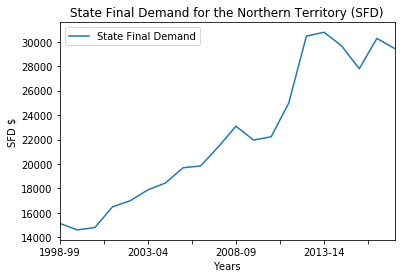

In [131]:
import matplotlib.pyplot as plt
SFD.plot(kind='line')

plt.title('State Final Demand for the Northern Territory (SFD)')
plt.ylabel('SFD $')
plt.xlabel('Years')

plt.show()

Unemployment Rate Chart

In [132]:
UN = NT_df[['Financial Year','Unemployment rate']]
UN.set_index('Financial Year', inplace=True)
UN.head()

,Unemployment rate
Financial Year,
1998-99,3.784849
1999-00,3.961754
2000-01,5.444008
2001-02,6.723936
2002-03,5.421898


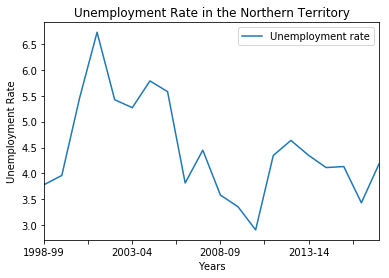

In [133]:
UN.plot(kind='line')

plt.title('Unemployment Rate in the Northern Territory')
plt.ylabel('Unemployment Rate')
plt.xlabel('Years')

plt.show()

Private Wage Growth Chart

In [134]:
PW = NT_df[['Financial Year','Private Wage Growth']]
PW.set_index('Financial Year', inplace=True)
PW.head()

,Private Wage Growth
Financial Year,
1998-99,2.686025
1999-00,2.332980
2000-01,3.005181
2001-02,2.883970
2002-03,3.031291


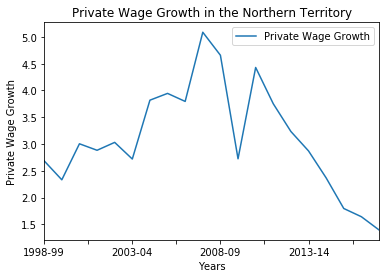

In [135]:
PW.plot(kind='line')

plt.title('Private Wage Growth in the Northern Territory')
plt.ylabel('Private Wage Growth')
plt.xlabel('Years')

plt.show()

Population Chart

In [136]:
P = NT_df[['Financial Year','Population']]
P.set_index('Financial Year', inplace=True)
P.head()

,Population
Financial Year,
1998-99,196012
1999-00,199149
2000-01,201743
2001-02,202251
2002-03,201725


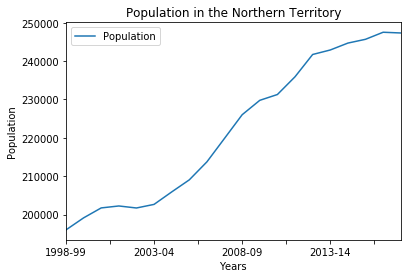

In [140]:
P.plot(kind='line')

plt.title('Population in the Northern Territory')
plt.ylabel('Population')
plt.xlabel('Years')

plt.show()

#### Correlation Analysis

Population and State Final Demand

In [141]:
NT_df['Population'].corr(NT_df['State Final Demand'])

0.9684868100105513

In [142]:
NT_df['Unemployment rate'].corr(NT_df['Private Wage Growth'])

0.04100228569340088